# Behavioral analysis of openfMRI dataset ds102 (Flanker task)

See also https://openfmri.org/dataset/ds000102/

## Import libraries

In [74]:
import pandas

In [75]:
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import numpy as np
%matplotlib inline

## Write a regular expression that extracts important info from filename

In [76]:
reg = re.compile('.*/sub-(?P<subj_idx>[0-9]+)/func/sub-[0-9]+_task-flankertask_run-(?P<run>[0-9]+)_events.tsv')

Get files

In [77]:
fns = glob.glob(os.path.join(os.environ['HOME'], 'data/openfmri/ds102/sub*/func/sub-*_task-flankertask_run-*_events.tsv'))

Loop over files and make a dataframe, using the regular expression to insert subject info

In [78]:
dfs = []

for fn in fns:
    d = reg.match(fn).groupdict()
    
    dfs.append(pandas.read_csv(fn, sep='\t', index_col=False))
    dfs[-1]['subj_idx'] = d['subj_idx']
    dfs[-1]['run'] = d['run']
    
df = pandas.concat(dfs)

In [79]:
df['correct'] = df.Rsponse.map({0:'error', 1:'correct'})

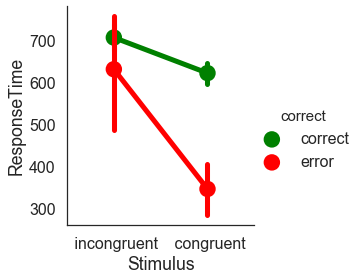

In [80]:
sns.factorplot('Stimulus', 'ResponseTime', 'correct', df, ci=67, units='subj_idx', hue_order=['correct', 'error'], palette=['green', 'red'])

Use groupby to get subject-wise summary of behavioral data

In [81]:
df.groupby(['subj_idx', 'Stimulus', 'Rsponse']).mean().ResponseTime

subj_idx  Stimulus      Rsponse
01         congruent    0           392.000000
                        1           507.434783
           incongruent  1           550.708333
02         congruent    1           610.583333
           incongruent  1           694.333333
03         congruent    0           490.000000
                        1           638.521739
           incongruent  1           766.166667
04         congruent    1           773.958333
           incongruent  1           863.583333
05         congruent    1           554.541667
           incongruent  1           658.166667
06         congruent    1           853.750000
           incongruent  1           857.375000
07         congruent    0           481.000000
                        1           423.391304
           incongruent  0           356.000000
                        1           489.434783
08         congruent    0             0.000000
                        1           548.304348
           incongruent  0   

## Use FacetGrid to make very informative plots with very little codfe

I think this looks a bit prettier than standard settings

In [82]:

sns.set_context('poster')
sns.set_style('white')

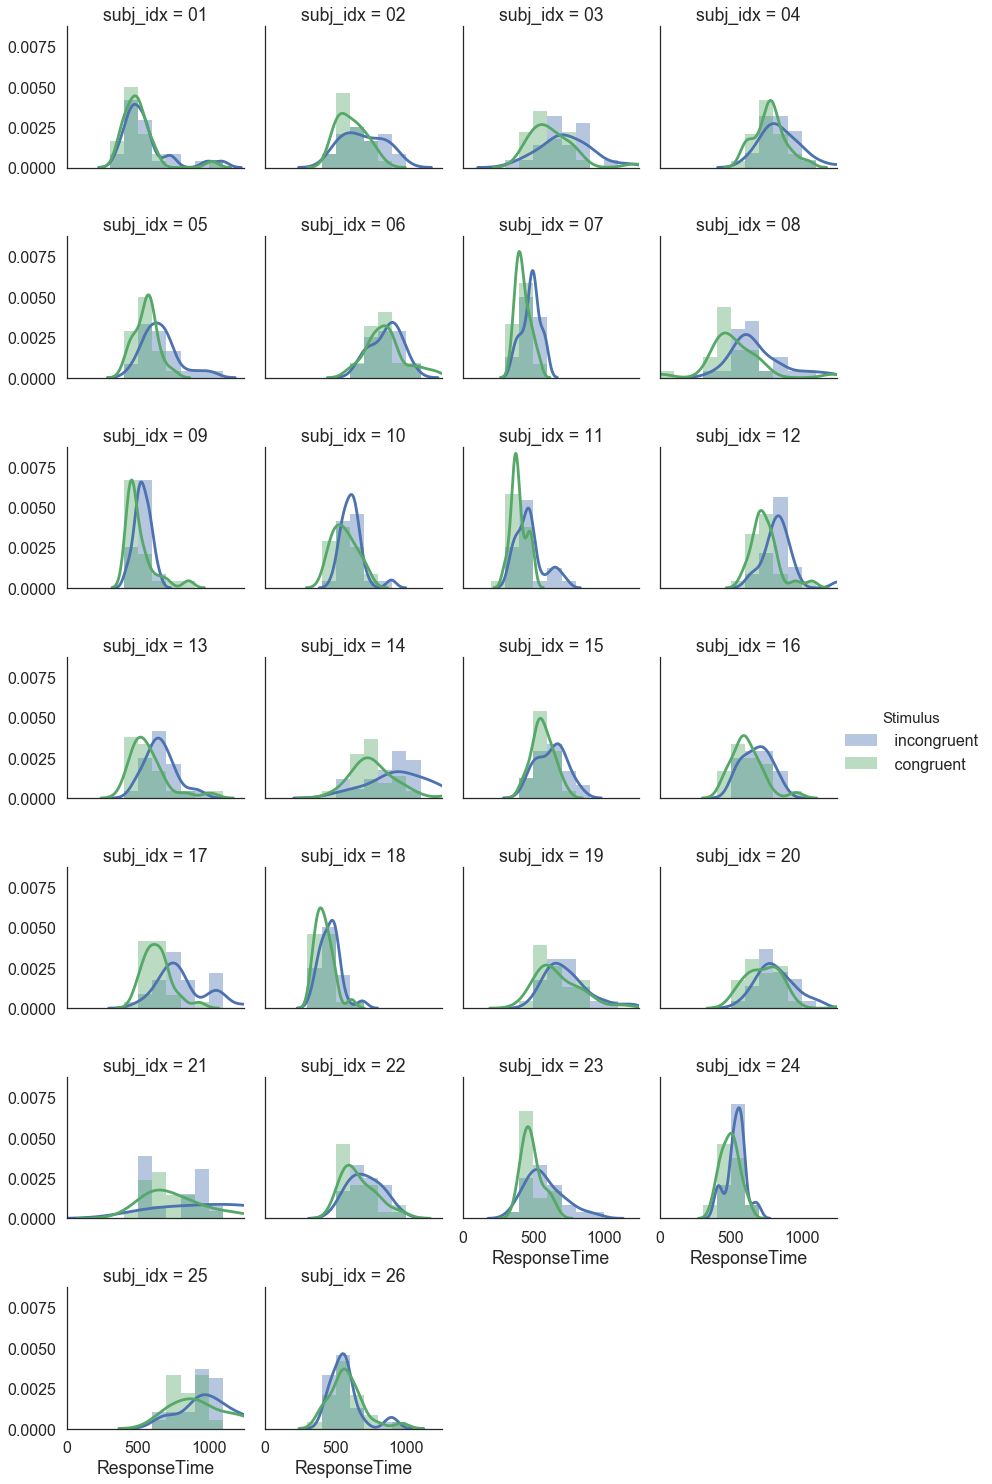

In [83]:
fac = sns.FacetGrid(df, col='subj_idx', col_wrap=4, hue='Stimulus')

fac.map(sns.distplot, 'ResponseTime', bins=np.arange(0, 1200, 100)).add_legend().set(xlim=(0, 1250))

## Fit Hierachidal DDM

In [84]:
import hddm

In [85]:
# RTs need to be in seconds (VERY important for informative priors!)

df['rt'] = df['ResponseTime'] / 1000.
df['response'] = df['Rsponse']

# Remove outliers (t0 can never be shorter than fastest trial)
df = df[df.rt > .3]

In [86]:
# Fit DDM, where drift rates varies depending on congruent versus incongruent sitmulus
model = hddm.HDDM(df, depends_on={'v':'Stimulus'})

In [87]:
# Use MAP fitting to get a reasonable starting point, otherwise (slice) MCMC sampler fails
model.find_starting_values()

/Users/gilles/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


We sample using MCMC. The number of samples is very low for speed considerations. If you want good estimates of the tails of the posteriors, definetly use more.

In [90]:
model.sample(1000, burn=50, thin=10)

 [-----------------100%-----------------] 1001 of 1000 complete in 144.9 secCould not generate output statistics for v( incongruent)
Could not generate output statistics for v_subj( incongruent).17
Could not generate output statistics for v( congruent)
Could not generate output statistics for t_subj.19
Could not generate output statistics for t_subj.10
Could not generate output statistics for v_subj( congruent).05
Could not generate output statistics for a_subj.08
Could not generate output statistics for v_subj( congruent).13
Could not generate output statistics for v_subj( congruent).16
Could not generate output statistics for v_subj( congruent).12
Could not generate output statistics for v_subj( incongruent).05
Could not generate output statistics for v_subj( incongruent).16
Could not generate output statistics for t_subj.25
Could not generate output statistics for a_subj.01
Could not generate output statistics for a_subj.13
Could not generate output statistics for t_subj.12
Could no

TypeError: 'NoneType' object is not subscriptable

Plotting a
Plotting a_std
Plotting v( congruent)
Plotting v( incongruent)
Plotting v_std
Plotting t
Plotting t_std


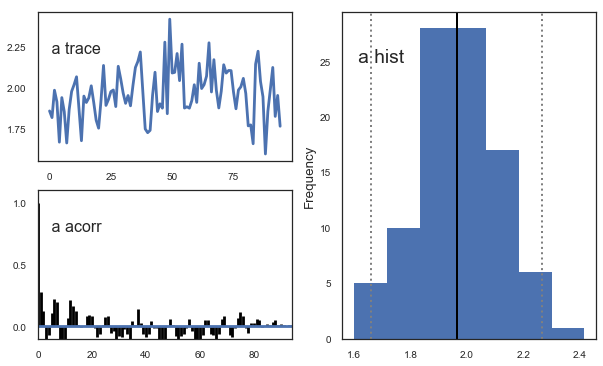

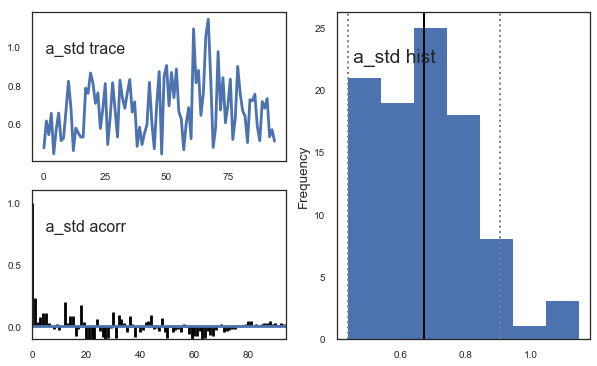

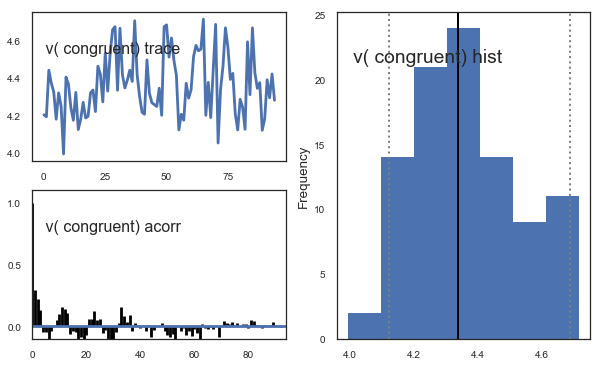

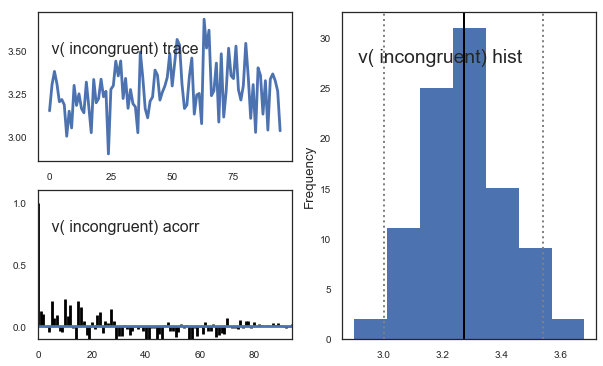

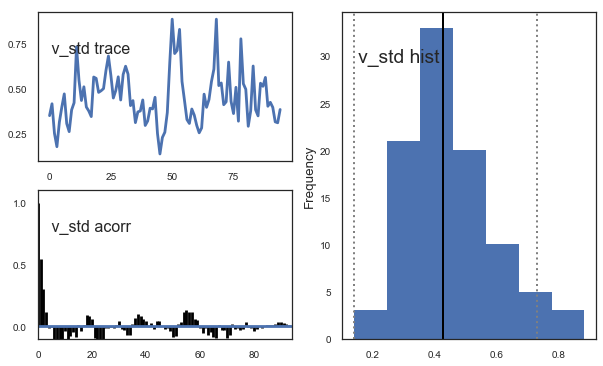

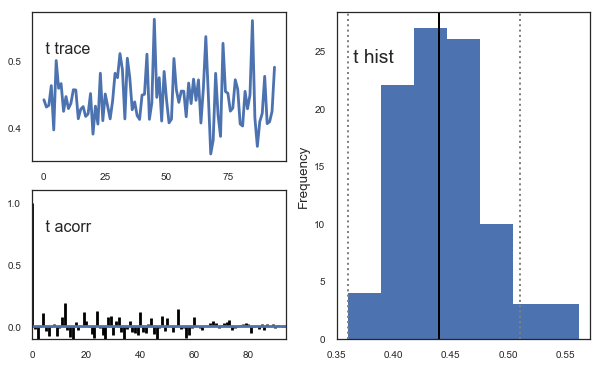

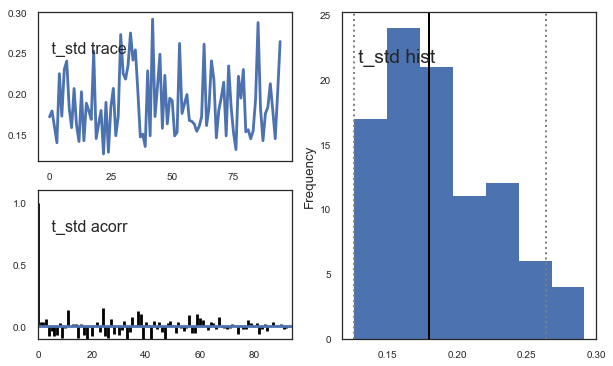

In [91]:
model.plot_posteriors()

In [93]:
sns.reset_orig()

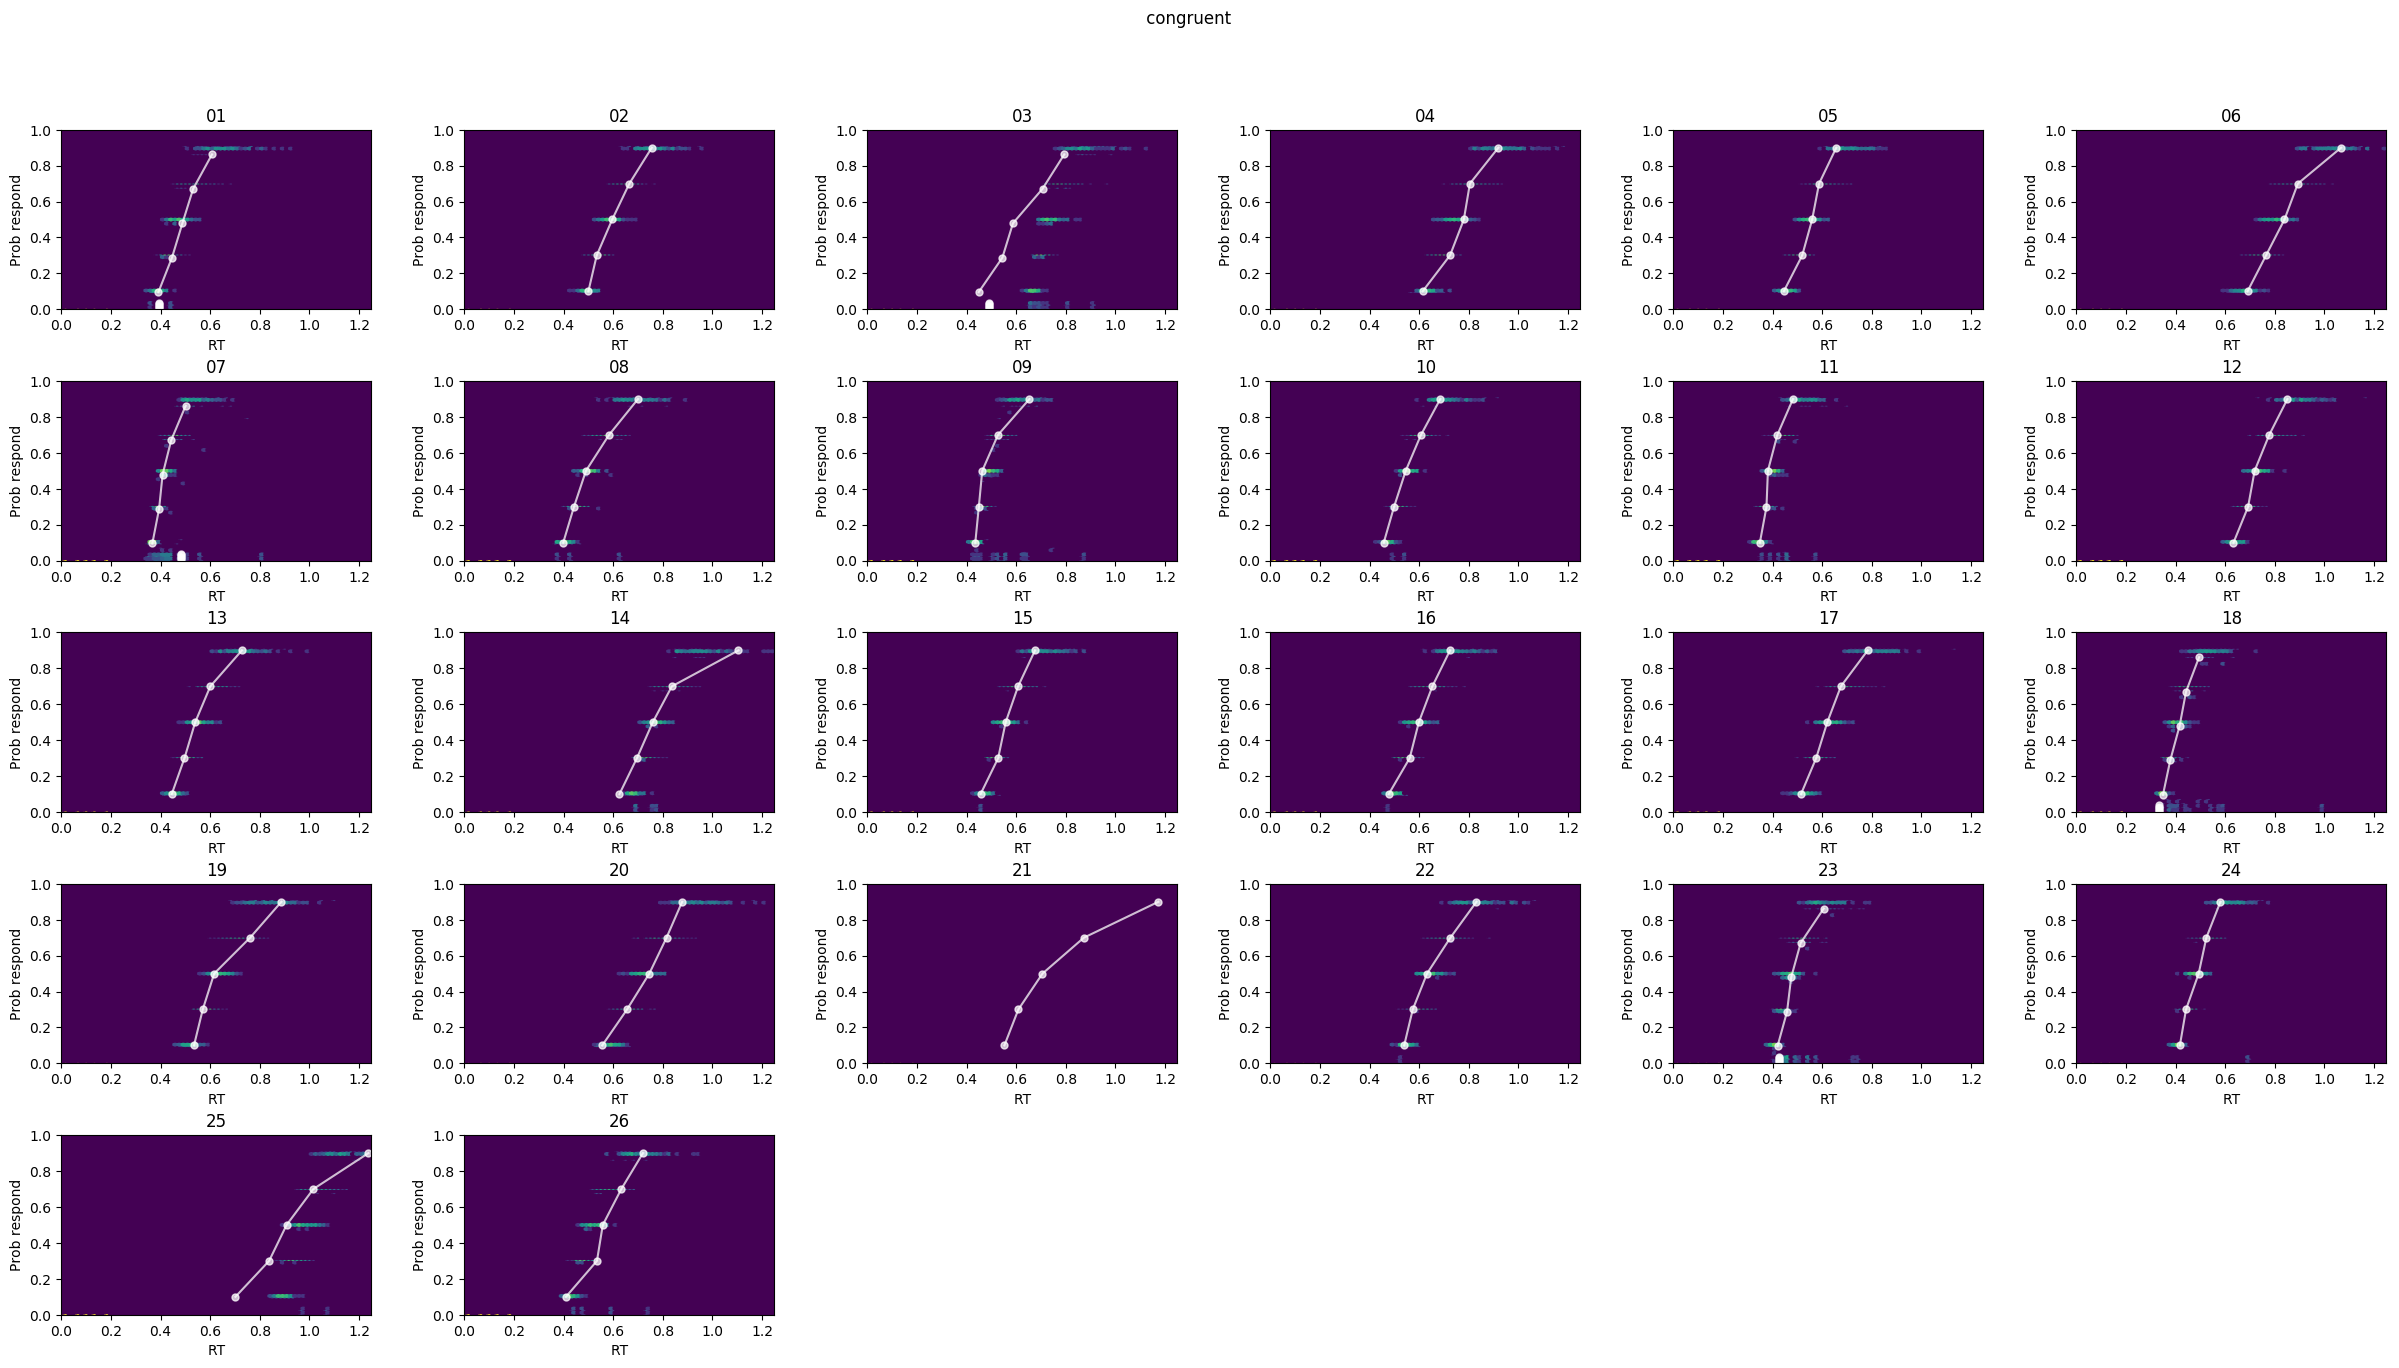

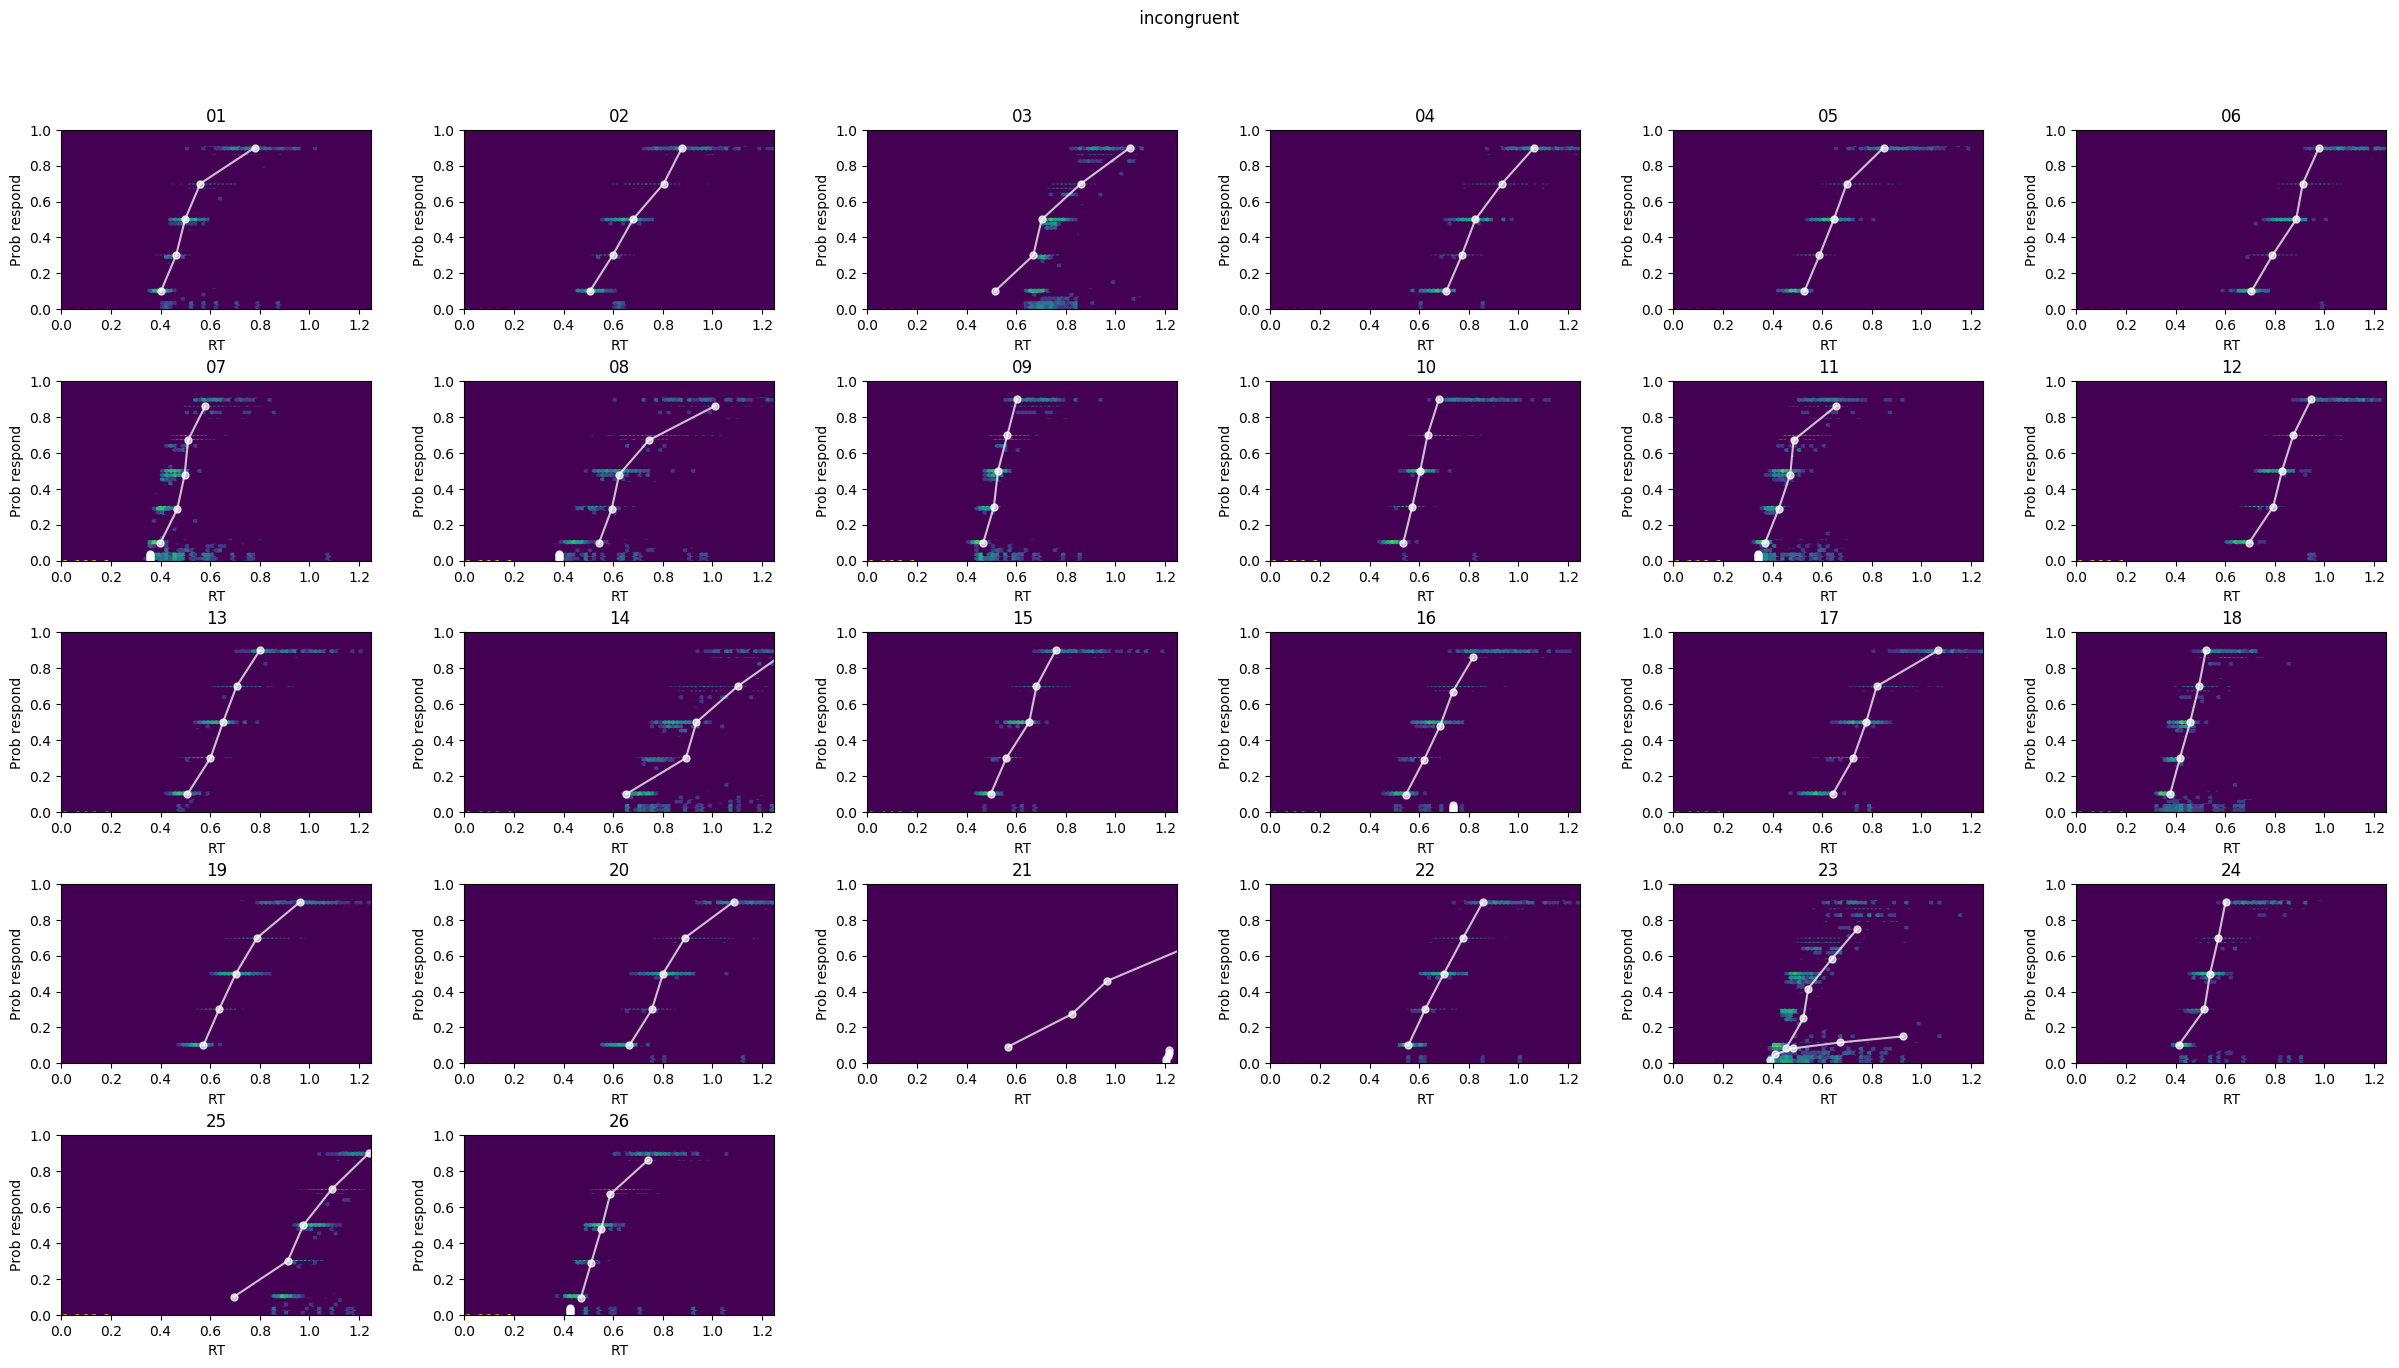

In [110]:
model.plot_posterior_quantiles(columns=6, figsize=(30, 15), value_range=(0, 1.25), samples=100, hexbin=True, data_plot_kwargs={'markersize':5, 'marker':'o', 'markerfacecolor':'white', 'color':'white', 'alpha':0.75})

In [113]:
subj_nodes = model.get_subj_nodes()
subj_nodes = subj_nodes[subj_nodes.knode_name == 'v_subj']
tmp = subj_nodes[['subj_idx', 'map', 'tag', 'node']]
tmp['tag'] = tmp['tag'].map(lambda x: x[0][1:])

/Users/gilles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [114]:
tmp

,subj_idx,map,tag,node
v_subj( congruent).01,01,2.049471,congruent,v_subj( congruent).01
v_subj( congruent).02,02,2.068387,congruent,v_subj( congruent).02
v_subj( congruent).03,03,2.004542,congruent,v_subj( congruent).03
v_subj( congruent).04,04,2.060166,congruent,v_subj( congruent).04
v_subj( congruent).05,05,2.076112,congruent,v_subj( congruent).05
v_subj( congruent).06,06,2.038096,congruent,v_subj( congruent).06
v_subj( congruent).07,07,2.072695,congruent,v_subj( congruent).07
v_subj( congruent).08,08,2.057593,congruent,v_subj( congruent).08
v_subj( congruent).09,09,2.079737,congruent,v_subj( congruent).09
v_subj( congruent).10,10,2.075462,congruent,v_subj( congruent).10


In [115]:
tmp['E'] = tmp['node'].apply(lambda node: node.trace[:].mean())

/Users/gilles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [116]:
s = tmp.pivot_table(index='subj_idx', columns='tag', values='E')
s

tag,congruent,incongruent
subj_idx,,
01,3.985537,3.223216
02,4.394947,3.340274
03,4.343104,3.422337
04,4.369257,3.380922
05,4.703891,3.401675
06,4.114103,3.681588
07,4.471615,3.189126
08,4.090039,2.635140
09,4.541088,3.510006


In [117]:
s.to_csv('drift_rates.csv')